In [1]:
import os, time 
from collections import OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc, rcParams
from linfitODR import linfit
%matplotlib inline

#Style stuff:

rcParams.update({'errorbar.capsize': 0})
rc('text', usetex=True)
rc('font', size=11)
rc('legend', fontsize=11)
rcParams.update({'font.size':11})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

def linestyles(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:linestyles['densely dashed'], 
             3250:linestyles['densely dotted'],
             3500:linestyles['densely dashdotted'],
             3750:linestyles['densely dashdotdotted']}
        return c[Tmin]
    else: 
        return '-'

def markers(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:'o', 
             3250:'x',
             3500:'^',
             3750:'D'}
        return c[Tmin]
    else: 
        return '-'


def colorize(age):
    if age==0.125:
        return 'k'
    elif age == 0.63:
        return 'r'

def multicolorize(age):
    c = []
    for a in age:
        if a==0.125:
            c.append('k')
        elif a == 0.63:
            c.append('r')
    print(c)
    return c
    
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orangered'),
         (3500.0,3749.0,'gold'),(3750.0,4000.0,'c')]

In [2]:
trange = {'M44': [
                   (3e3,7e3,'k', 5e28, 5e36, 0.630),   
                   (3e3,3.249e3,'red', 5e28, 5e36, 0.630),
                   (3.25e3,3.499e3,'orange', 5e28, 5e36, 0.630),
                   (3.5e3,3.749e3,'green', 5e28, 5e36, 0.630),
                   (3.75e3,4e3,'c', 5e28, 5e36, 0.630),
                 ],

     'Pleiades': [
                  (3e3,7e3,'k', 5e28, 5e36, 0.125),
                  (3e3,3.249e3,'red', 5e28, 5e36, 0.125),
                  (3.25e3,3.499e3,'orange', 5e28, 5e36, 0.125),
                  (3.5e3,3.749e3,'green', 5e28, 5e36, 0.125),
                  (3.75e3,4e3,'c', 5e28, 5e36, 0.125),
                  ],}
df = pd.DataFrame()
loc = '/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/'
test = 'run_06'
for key in trange.keys():
    
    for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
        print('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax))
        df2 = pd.read_csv('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax),
                         usecols = ['Tmax','Tmin','alpha',
                                'alpha_err','beta','beta_err',
                                'maxenerg','n_obj','nflares',
                                   'cluster',])
        df2['age'] = age
        df = df.append(df2)
print(df.shape)
newres = df.drop_duplicates()
newres.alpha = -newres.alpha

/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3000.0_7000.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3000.0_3249.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3250.0_3499.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3500.0_3749.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_Pleiades_3750.0_4000.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3000.0_7000.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3000.0_3249.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3250.0_3499.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3500.0_3749.0_FFD.csv
/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_06_M44_3750.0_4000.0_FFD.csv
(1276, 11)


/home/eilin/.local/lib/python3.4/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(1276, 16)
3249.0 (8, 16)
3249.0 (25, 16)
3499.0 (5, 16)
3499.0 (9, 16)
3749.0 (0, 16)
3749.0 (8, 16)
4000.0 (0, 16)
4000.0 (11, 16)
7000.0 (24, 16)
7000.0 (86, 16)


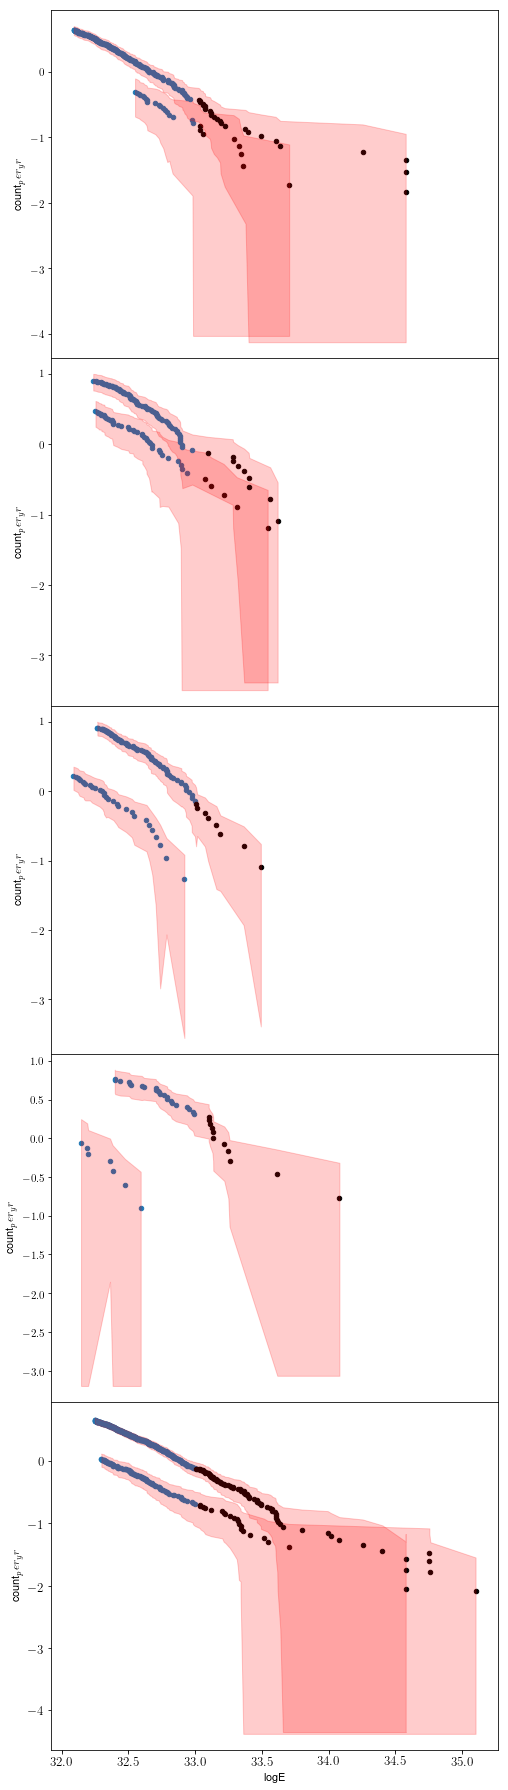

In [23]:
df = pd.DataFrame()
for key in trange.keys():
     for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
        df2 = pd.read_csv('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax))

        df2['age'] = age
        df = df.append(df2)
    
print(df.shape)    
fig, ax = plt.subplots(ncols=1, nrows=5,figsize=(8,32), sharex=True)
i=0
for name, g in df.groupby('Tmax'):
    for cluster, f in g.groupby('cluster'):
        f=f.sort_values(by='logE')
        f1 = f[f.logE<33]
        f2 = f[f.logE>33]
        print(name,f2.shape)
        f1.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i])
        if f2.shape[0] > 0:
            f2.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],color='black')
        ax[i].fill_between(f.logE, f.count_per_yr-f.low_yerr, f.count_per_yr+f.high_yerr,
                         alpha=0.2,color='r')
        
    i+=1
    

plt.tick_params(axis = 'both', labelsize = 13)

#plt.tight_layout()
plt.subplots_adjust(hspace=0)

In [4]:
def import_flares(cluster, test, oid):
    
    oid = int(float(oid))
    
    loc = 'stars_shortlist/{}/results/{}/results'.format(cluster,test)
    flux = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    flares = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])

    return flux, flares

def print_susp(oid, cluster, test):

    try:
        flux, flares = import_flares(cluster, test, oid)
        l = flares.shape[0]
        maxid = flux.shape[0]-1
        fig, ax = plt.subplots(ncols=l,nrows=1,figsize=(5*l,3.5))
        if l == 1:
            ax = [ax]
        
        for i, row in flares.iterrows():

            ax[i].plot(flux.time.iloc[row.istart-50:row.istop+50],
                     (flux.flux_gap-flux.flux_model).iloc[row.istart-50:row.istop+50],
                     linewidth=2,
                     color='green',)
            flare = (flux.flux_gap-flux.flux_model).iloc[row.istart:row.istop+1]
            ax[i].plot(flux.time.iloc[row.istart:row.istop+1],
                     flare,
                     linewidth=2,
                     color='red',)
            ax[i].set_xlim(flux.time.iloc[max(row.istart-50,0)],flux.time.iloc[min(row.istop+50,maxid)])
            ax[i].set_ylim(flare.min()*(-.2),flare.max()*1.1)
            ax[i].set_title('EPIC {}: {}-{}'.format(oid,row.istart,row.istop))
        plt.savefig('{}_highenerg'.format(oid),dpi=300)
        plt.close()
    except (FileNotFoundError, OSError):
        pass
    return


df = pd.DataFrame()
for key in trange.keys():
     for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
        if Tmax == 7000.:
            df2 = pd.read_csv('{}{}_{}_{}_{}_energs.csv'.format(loc,test,key,Tmin,Tmax))

            df2['age'] = age
            df = df.append(df2)
            

for cluster in ['M44','Pleiades']:
    
    flarelist = list(set(df[df.energ_true>1e33].EPIC.tolist()))
    for i in flarelist:
        print_susp(i,cluster, test)

1


/home/eilin/.local/lib/python3.4/site-packages/pandas/core/indexing.py:1198: FutureWarning: slice indexers when using iloc should be integers and not floating point
  return self._getitem_axis(key, axis=0)
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:33: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point


1
9
2
32
4
2
3
2
2
5
3
2
1
2
6
2
4
1
2
11
2
5
5
3
9
2
3
2
3
10
6
6
2
2
3
4
2
6
5
2
3
8
2
5
2
4
1
1
4
3
2
5
7
12
2
2
4
9
4
8
7
1
3
3
9
4
7
3
8
4
3
8
3
4
2
2
6
5
4
9
2
5


In [6]:
len(flarelist)


83

In [7]:
df[df.energ_true>1e33].shape

(110, 17)